<a href="https://colab.research.google.com/github/shailu20aug/shailendra-chouhan/blob/main/Shailendra_Chouhan_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

#### Class Notes: Import libraries like Tensorflow, Numpy, Pandas, pathlib, glob, keras, matplotlib have been imported below.

In [ ]:
import pathlib
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import tensorflow as tf
tf.config.run_functions_eagerly(True)
#from tensorflow import keras
#import tensorflow.keras as keras
#import tensorflow.keras as keras
import keras
from keras import models
from keras.models import Sequential
from keras import layers
from keras.layers import BatchNormalization
from keras.preprocessing.image import load_img
import glob
import warnings
warnings.filterwarnings('ignore')

We will now mount the google drive to access our dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
print('Current Working Directory is :',os.getcwd())

Mounted at /content/gdrive
Current Working Directory is : /content


### Important Library Versions:

In [ ]:
print('Pandas Version is:',pd.__version__)
print('Numpy Version is:',np.__version__)
print('Tensorflow Version is:',tf.__version__)
print('Keras Version is:',keras.__version__)

Pandas Version is: 2.0.3
Numpy Version is: 1.25.2
Tensorflow Version is: 2.15.0
Keras Version is: 2.15.0


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images
a= os.getcwd()
b= os.path.join(a,'/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration')
c = os.path.join(a,'/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train')
d = os.path.join(a,'/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test')
data_dir = pathlib.Path(b)
data_dir_train = pathlib.Path(c)
data_dir_test = pathlib.Path(d)
print (b)
print(c)
print(d)

/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration
/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train
/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test


In [ ]:
## Below we will confirm the number of total images in the dataset and their distribution as Train and Test sets.
data_set= list(data_dir.rglob('*/*.jpg'))
image_count_set = len(list(data_dir.rglob('*/*.jpg')))
print(image_count_set)

train_d_set= list(data_dir_train.rglob('*/*.jpg'))
image_count_train = len(list(data_dir_train.rglob('*/*.jpg')))
print(image_count_train)

test_d_set= list(data_dir_test.rglob('*/*.jpg'))
image_count_test = len(list(data_dir_test.rglob('*/*.jpg')))
print(image_count_test)

2371
2253
118


In [ ]:
## Now we will take a random image from the dataset and check for it's size, format, mode and type.
img = load_img(train_d_set[2238])
print(img.size)
print(img.format)
print(img.mode)
print(type(img))
img.show()

(600, 450)
JPEG
RGB
<class 'PIL.JpegImagePlugin.JpegImageFile'>


### Load using keras.preprocessing

#### Preprocessing of Training and Validation dataset. We will create separate training and validation datasets out of images available in training data directory.

Some fixed parameters for the loader: images are processed in batches of 32 images each and each image size changed to 180*180.

In [ ]:
batch_size = 32
img_height = 180
img_width = 180
seed = 123
num_classes = 9
epochs =20 ## All models shall be trained for 20 epochs unless mentioned otherwise.

### Creation of preprocessed training & validation dataset: (80 % for training & 20 % for validation)

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,

    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size= batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=seed,
    validation_split= .2,
    subset= "training")


val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,

    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=seed,
    validation_split= .2,
    subset= "validation")

Found 2253 files belonging to 9 classes.
Using 1803 files for training.
Found 2253 files belonging to 9 classes.
Using 450 files for validation.


### List out all the classes of skin cance and store them in a list.

In [ ]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### One instance of all the nine classes present in the training dataset have been visualised below.

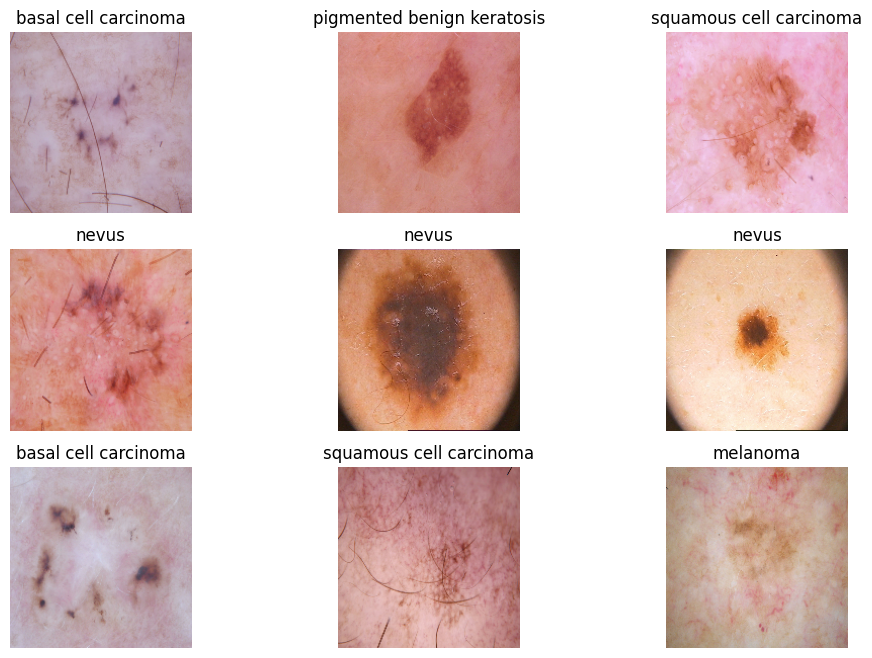

In [ ]:
plt.figure(figsize=(12, 8))
labels = list(class_names)
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Initial Model

For accurate detection of  9 classes present in the dataset below is a sequential model built in Keras. The model consist of Five convolutional layers of 2x32, 2x64 and 128 features each using 3x3 kernel. 'relu' activation function have been used in all three convolutional layers. Pixel values of images have been rescaled between 0 and 1 using standardisation method of rescaling.  Each convolutional layer have been followed by a 2*2 Max pooling layer. At the end Dense layer with 128 features with 'relu' have been used and it is followed by another dense layer for classification with 'softmax' as activation function.

Further, to keep the output image size same as input, we have used padding as 'same' and used strides of 1 pixel in both directions.

In [ ]:
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),

  tf.keras.layers.Conv2D(32, 3, activation='relu',padding='same',strides=(1,1)),
  tf.keras.layers.Conv2D(32, 3, activation='relu',padding='same',strides=(1,1)),
  tf.keras.layers.MaxPooling2D(),

  tf.keras.layers.Conv2D(64, 3, activation='relu',padding='same',strides=(1,1)),
  tf.keras.layers.Conv2D(64, 3, activation='relu',padding='same',strides=(1,1)),
  tf.keras.layers.MaxPooling2D(),

  tf.keras.layers.Conv2D(128, 3, activation='relu',padding='same',strides=(1,1)),
  tf.keras.layers.MaxPooling2D(),

  tf.keras.layers.Flatten(),

  tf.keras.layers.Dense(256, activation='relu'),

  tf.keras.layers.Dense(num_classes, activation= 'softmax')
])

**### Model Compilation, Fitting, Visualization of Results and Summary.**

'adam' optimiser and 'SparseCategoricalCrossentropy' loss function have been used for their obvious advantages as learned from theory.

Since we will not be making any change in optimiser and loss function, code for the compilation, model fitting, model summary and visualisation will remain same. Therefore, it's better to define a function for these repetative actions. For this purpose function named model_compilation_fit_summary have been and defined and shall be used for later instances of the model compilation, fitting and visualisation.

In [ ]:
def model_compilation_fit_summary():
 model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

 history = model.fit(train_ds,validation_data=val_ds,epochs=epochs )

 model.summary()

 acc = history.history['accuracy']
 val_acc = history.history['val_accuracy']

 loss = history.history['loss']
 val_loss = history.history['val_loss']

 epochs_range = range(epochs)

 plt.figure(figsize=(12, 4))
 plt.subplot(1, 2, 1)
 plt.plot(epochs_range, acc, label='Training Accuracy', color='green')
 plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='red')
 plt.legend(loc='best')
 plt.title('Training and Validation Accuracy')

 plt.subplot(1, 2, 2)
 plt.plot(epochs_range, loss, label='Training Loss',color='blue')
 plt.plot(epochs_range, val_loss, label='Validation Loss',color='orange')
 plt.legend(loc='best')
 plt.title('Training and Validation Loss')
 plt.show()


**Compilation, Training & Fitting, Summary and Visualization of Initial Model**

Epoch 1/20
57/57 [==============================] - 279s 1s/step - loss: 1.9532 - accuracy: 0.3344 - val_loss: 1.6803 - val_accuracy: 0.3756
Epoch 2/20
57/57 [==============================] - 8s 139ms/step - loss: 1.5905 - accuracy: 0.4537 - val_loss: 1.7600 - val_accuracy: 0.3489
Epoch 3/20
57/57 [==============================] - 9s 150ms/step - loss: 1.5071 - accuracy: 0.4864 - val_loss: 1.4773 - val_accuracy: 0.4556
Epoch 4/20
57/57 [==============================] - 8s 138ms/step - loss: 1.3609 - accuracy: 0.5236 - val_loss: 1.4349 - val_accuracy: 0.4756
Epoch 5/20
57/57 [==============================] - 8s 140ms/step - loss: 1.2910 - accuracy: 0.5452 - val_loss: 1.5186 - val_accuracy: 0.4333
Epoch 6/20
57/57 [==============================] - 8s 137ms/step - loss: 1.2467 - accuracy: 0.5663 - val_loss: 1.3763 - val_accuracy: 0.5089
Epoch 7/20
57/57 [==============================] - 8s 139ms/step - loss: 1.1469 - accuracy: 0.5818 - val_loss: 1.3826 - val_accuracy: 0.5178
Epoch 8

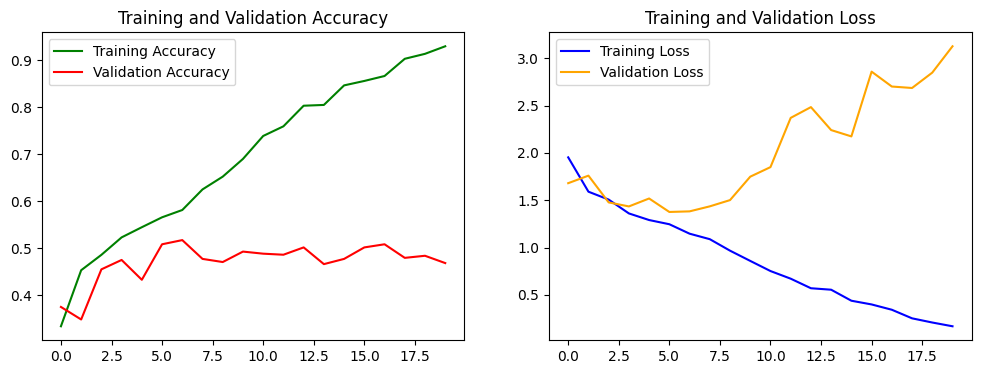

In [ ]:
model_compilation_fit_summary()

### Observations about the model & it's performance:

From the above plots, it is clearly evident that the model is overfitting. While training accuracy is continuously increasing with every epoch, validation accuracy remains stagnated just above 40 %. Similary, the training loss is continuousy decreasing with every epoch but reverse is happening with validation loss. Both of these establishes clear overfitting of the model.

### Strategy to solve overftting issue.

To address the issue of overfitting, initially we will use the data augmentation techniques including random flip, random roation and random zoom of the images.
In the next step of addressal of overfitting issue, we will use dropout of .25 in the model itself.

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomCrop(img_height,img_width),
  ]
)


### Visualization of how augmentation strategy works for one instance of training image.isualization of how augmentation strategy works for one instance of training image.

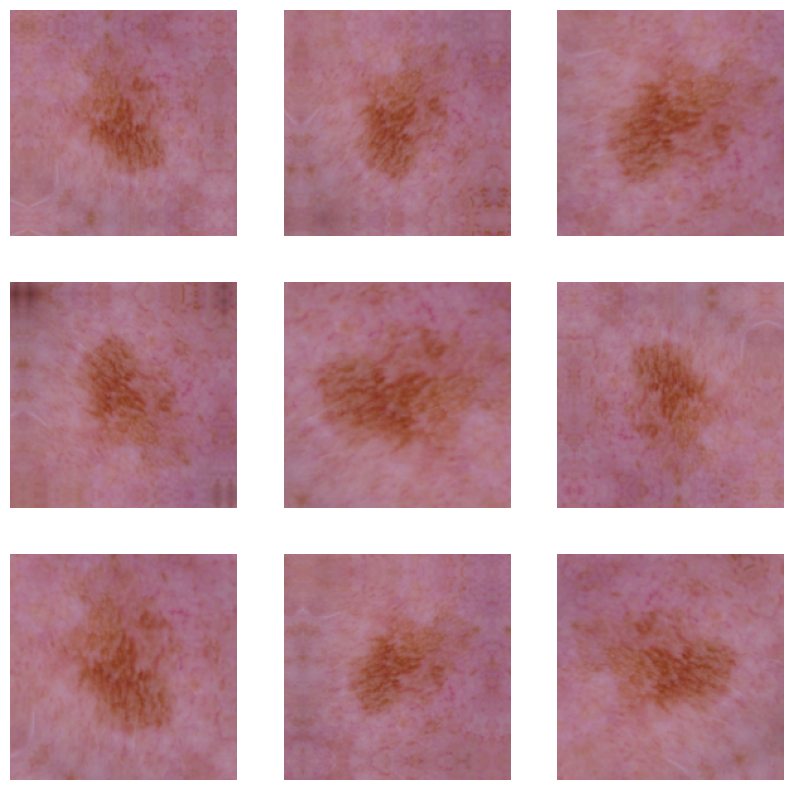

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### New model with dropout layer and data_augmentation.



In [ ]:
model = Sequential([data_augmentation,
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu',padding='same',strides=(1,1)),
  tf.keras.layers.Conv2D(32, 3, activation='relu',padding='same',strides=(1,1)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu',padding='same',strides=(1,1)),
  tf.keras.layers.Conv2D(64, 3, activation='relu',padding='same',strides=(1,1)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, activation='relu',padding='same',strides=(1,1)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation= 'softmax')
])


**Compilation, Training & Fitting, Summary and Visualization of model with Image Augmentation and Use of dropout layer**

Epoch 1/20
57/57 [==============================] - 12s 176ms/step - loss: 2.0371 - accuracy: 0.2341 - val_loss: 1.8684 - val_accuracy: 0.2844
Epoch 2/20
57/57 [==============================] - 10s 178ms/step - loss: 1.7968 - accuracy: 0.3677 - val_loss: 1.6918 - val_accuracy: 0.3489
Epoch 3/20
57/57 [==============================] - 10s 182ms/step - loss: 1.5577 - accuracy: 0.4526 - val_loss: 1.5905 - val_accuracy: 0.4267
Epoch 4/20
57/57 [==============================] - 10s 179ms/step - loss: 1.4990 - accuracy: 0.4825 - val_loss: 1.5568 - val_accuracy: 0.4489
Epoch 5/20
57/57 [==============================] - 10s 179ms/step - loss: 1.4890 - accuracy: 0.4786 - val_loss: 1.4961 - val_accuracy: 0.4467
Epoch 6/20
57/57 [==============================] - 11s 186ms/step - loss: 1.4335 - accuracy: 0.4986 - val_loss: 1.5332 - val_accuracy: 0.4311
Epoch 7/20
57/57 [==============================] - 10s 171ms/step - loss: 1.3907 - accuracy: 0.5263 - val_loss: 1.3962 - val_accuracy: 0.4867

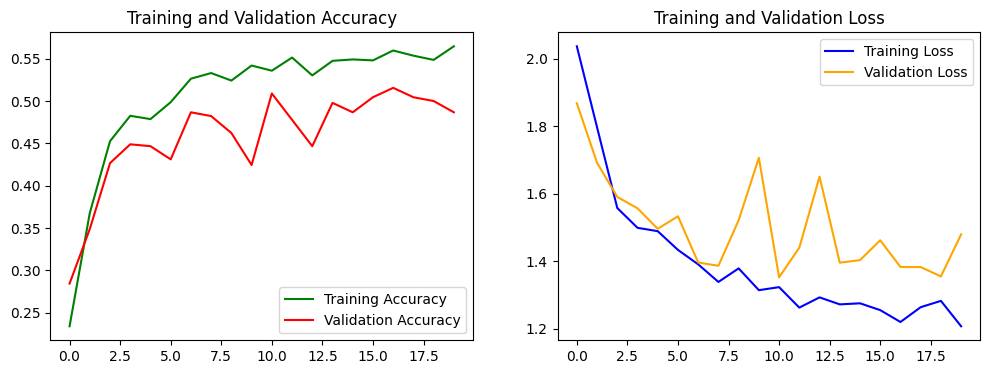

In [ ]:
model_compilation_fit_summary()

#### Observations:

While the issue of overfitting seems to be addressed as there is a downward trend in the validation loss function. However, there comes a significant reduction in the training accuraccy without any observable change in the validation accuracy. Therefore, we can say to some extent that now this seems a case of uderfitting. Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Now , to find the root cause, we will look for the distribuion of the dataset to find some data sufficiency related issue. Are some classes under represented for training accuracy or some over represented.

## Class Distribution:

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
[114, 386, 95, 438, 357, 466, 77, 181, 139]


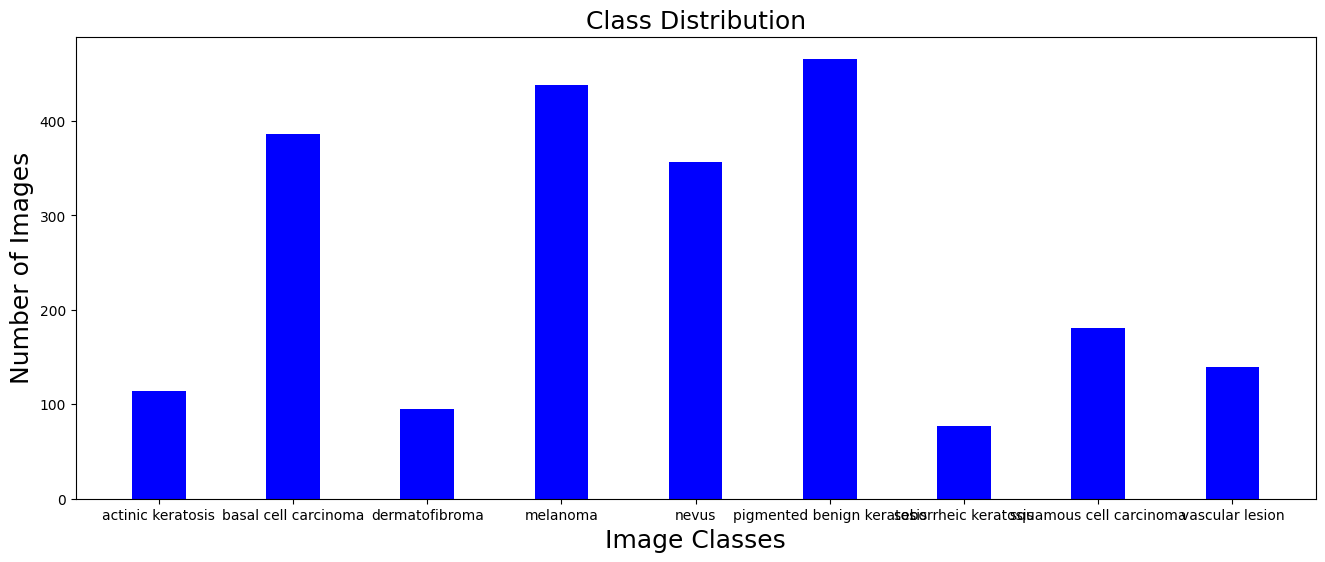

In [ ]:
class_count_list=[]
for i in range(9):

 class_data_path = os.path.join(data_dir_train,class_names[i])
#print(class_data_path = os.path.join(data_dir_train,'class_names[i]'))
 class_data = pathlib.Path(class_data_path)
 #print(class_data)
 data_set= list(class_data.glob('*.jpg'))
 image_count= len(list(class_data.glob('*.jpg')))
 class_count_list.append(image_count)
print(class_names)
print(class_count_list)

plt.figure(figsize=(16, 6))
plt.ylabel('Number of Images', fontsize =18)
plt.xlabel('Image Classes', fontsize =18)
plt.title('Class Distribution', fontsize =18)
plt.bar(class_names, class_count_list, color ='blue', width =0.4)
plt.show()

## Findings about class distribution:

Class Seborrheic Keratosis is having least number of images ie. only 77.

Class Distribution is dominated by Pigmented Benign Keratosis and Melanoma classes both of them are represented by more than 425 images each which is more than 500 % times of the representation of the class Seborrheic Keratosis and more than 400 % times of the representation of the class Dermatofibroma.

Now we can attribute the low accuracy of our above model to the issue of class imbalance in the training data.


## Rectification of the class imbalance.

we will use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the class remain under represented.

We will add 500 images per class of the training data so that the least representative class size will increase to 577 images which will be more than 50 % of the size of the highest representation class with 962 images.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure have been followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
path_to_training_dataset= pathlib.Path(data_dir_train)
print(path_to_training_dataset)
import Augmentor
for i in class_names:
    print(str(path_to_training_dataset) + '/' +i)
    p = Augmentor.Pipeline(str(path_to_training_dataset) + '/' + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)

/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train
/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis
Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C2DAA62E410>: 100%|██████████| 500/500 [00:23<00:00, 21.35 Samples/s]


/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma
Initialised with 386 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C2EBAF7B430>: 100%|██████████| 500/500 [00:25<00:00, 19.85 Samples/s]


/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma
Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C2DAA79BA30>: 100%|██████████| 500/500 [00:20<00:00, 23.83 Samples/s]


/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma
Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7C2DD2188F40>: 100%|██████████| 500/500 [01:26<00:00,  5.80 Samples/s]


/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus
Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=576x768 at 0x7C2DD2189960>: 100%|██████████| 500/500 [01:27<00:00,  5.70 Samples/s]


/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis
Initialised with 466 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C2E2EBFA320>: 100%|██████████| 500/500 [00:20<00:00, 25.00 Samples/s]


/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis
Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7C2DAA7E6B90>: 100%|██████████| 500/500 [00:38<00:00, 13.05 Samples/s]


/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma
Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C2DAA514CA0>: 100%|██████████| 500/500 [00:19<00:00, 25.38 Samples/s]


/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion
Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7C2DD21861D0>: 100%|██████████| 500/500 [00:20<00:00, 24.81 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

NameError: name 'data_dir_train' is not defined

### Lets see the distribution of augmented data after adding new images to the original training data.

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
[614, 886, 595, 938, 857, 966, 577, 681, 639]


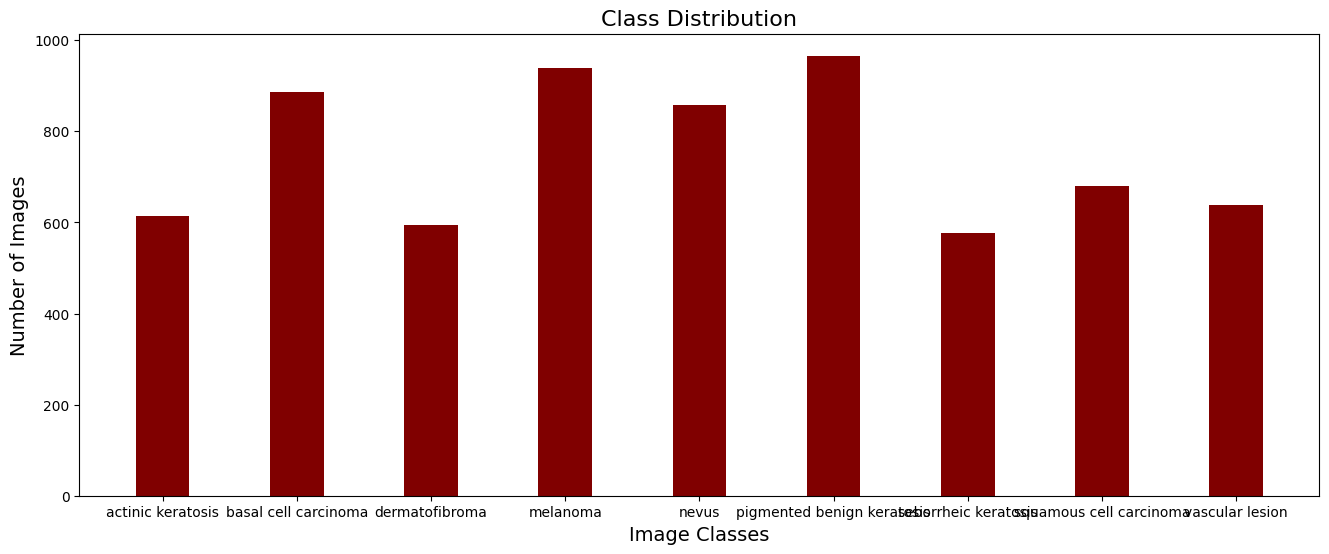

In [ ]:
class_count_list=[]
for i in range(9):
 class_data_path = os.path.join(data_dir_train,class_names[i])
 class_data = pathlib.Path(class_data_path)
 #print(class_data)
 data_set= list(class_data.rglob('*.jpg'))
 image_count= len(list(class_data.rglob('*.jpg')))
 class_count_list.append(image_count)
print(class_names)
print(class_count_list)

plt.figure(figsize=(16, 6))
plt.xlabel('Image Classes', fontsize=14)
plt.ylabel('Number of Images', fontsize=14)
plt.title('Class Distribution',fontsize =16)
plt.bar(class_names, class_count_list, color ='maroon', width =0.4)
plt.show()

### As clearly visible above, classes are more balanced now and each class is very well represented.Neither of the class is overly dominant either.

##  Training of  the model on the augmented training dataset.

## Creation of training and validation data from augmented dataset.

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)



val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)


NameError: name 'data_dir_train' is not defined

## Sequential Model including Batch Normalisation.

Below model with use of BatchNormalization with every convulational layer and use of dropout of 0.25 after every maxpooling layer and 0.4 after fully connected layer have been considered after trying several combination of dropouts with and without BatchNormaization. While, training accuracy have been consistently crossing 90% for most of the models, validation accuracy is generally hovering between 80-90 %.

In [ ]:
model = Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu',padding='same',strides=(1,1)),
  tf.keras.layers.Conv2D(32, 3, activation='relu',padding='same',strides=(1,1)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.25),

  tf.keras.layers.Conv2D(64, 3, activation='relu',padding='same',strides=(1,1)),
  tf.keras.layers.Conv2D(64, 3, activation='relu',padding='same',strides=(1,1)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.25),

  tf.keras.layers.Conv2D(128, 3, activation='relu',padding='same',strides=(1,1)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.25),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.25),

  tf.keras.layers.Dense(num_classes, activation= 'softmax')
])


**Compilation, summary and Visualization of results from Model with multiple dropout layers.**

In [ ]:
model_compilation_fit_summary()

NameError: name 'train_ds' is not defined

In [ ]:
model = Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu',padding='same',strides=(1,1)),
  tf.keras.layers.Conv2D(32, 3, activation='relu',padding='same',strides=(1,1)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.20),

  tf.keras.layers.Conv2D(64, 3, activation='relu',padding='same',strides=(1,1)),
  tf.keras.layers.Conv2D(64, 3, activation='relu',padding='same',strides=(1,1)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.20),

  tf.keras.layers.Conv2D(128, 3, activation='relu',padding='same',strides=(1,1)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.20),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.20),

  tf.keras.layers.Dense(num_classes, activation= 'softmax')
])

In [ ]:
model_compilation_fit_summary()

In [ ]:
model = Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu',padding='same',strides=(1,1)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(32, 3, activation='relu',padding='same',strides=(1,1)),
  #tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(),
  #tf.keras.layers.Dropout(0.40),

  tf.keras.layers.Conv2D(64, 3, activation='relu',padding='same',strides=(1,1)),
  #tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(64, 3, activation='relu',padding='same',strides=(1,1)),
  tf.keras.layers.MaxPooling2D(),
  #tf.keras.layers.Dropout(0.40),

  tf.keras.layers.Conv2D(128, 3, activation='relu',padding='same',strides=(1,1)),
  #tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(),
  #tf.keras.layers.Dropout(0.40),

  tf.keras.layers.Flatten(),
   # tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(256, activation='relu'),
  #tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.20),

  tf.keras.layers.Dense(num_classes, activation= 'softmax')
])

In [ ]:
model_compilation_fit_summary()

In [ ]:
model = Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu',padding='same',strides=(1,1)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(32, 3, activation='relu',padding='same',strides=(1,1)),
  #tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.20),

  tf.keras.layers.Conv2D(64, 3, activation='relu',padding='same',strides=(1,1)),
  #tf.keras.layers.BatchNormalization(),
  #tf.keras.layers.Conv2D(64, 3, activation='relu',padding='same',strides=(1,1)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.20),

  tf.keras.layers.Conv2D(128, 3, activation='relu',padding='same',strides=(1,1)),
  #tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.20),

  tf.keras.layers.Flatten(),
   # tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(256, activation='relu'),
  #tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.20),

  tf.keras.layers.Dense(num_classes, activation= 'softmax')
])

In [ ]:
model_compilation_fit_summary()

In [ ]:
model = Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu',padding='same',strides=(1,1)),
  #tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(32, 3, activation='relu',padding='same',strides=(1,1)),
  #tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(),
  #tf.keras.layers.Dropout(0.20),

  tf.keras.layers.Conv2D(64, 3, activation='relu',padding='same',strides=(1,1)),
  #tf.keras.layers.BatchNormalization(),
  #tf.keras.layers.Conv2D(64, 3, activation='relu',padding='same',strides=(1,1)),
  tf.keras.layers.MaxPooling2D(),
  #tf.keras.layers.Dropout(0.20),

  tf.keras.layers.Conv2D(128, 3, activation='relu',padding='same',strides=(1,1)),
  #tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.20),

  tf.keras.layers.Flatten(),
   # tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(256, activation='relu'),
  #tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.20),

  tf.keras.layers.Dense(num_classes, activation= 'softmax')
])

In [ ]:
model_compilation_fit_summary()

## Analysis of Model and Results.

Final model after image augmentation, class normalization, use of dropout and BatchNormalization is giving satisafctory results for both training and validation activities. While determination of best model involves lots of permutation and combination of various optimising model paramaters, above model is also giving satisfactory accuracy of    % for training and  % for validation.